In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf 
import cv2
import shutil
from PIL import Image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy, CategoricalAccuracy
from tensorflow.keras.models import load_model
from tensorflow.keras import layers
from keras.layers import BatchNormalization
from keras import regularizers
from tensorflow.keras.regularizers import l2
import imghdr
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator

C:\Users\jason\AppData\Local\Temp\ipykernel_21332\3266627147.py:21: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [9]:
# limiting memory use
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [11]:
image_exts = ['jpeg', 'jpg', 'bmp', 'png']

In [13]:
data_dir = 'data1'
problem_dir = 'problem_images'

os.makedirs(problem_dir, exist_ok=True)

# Loop through all images, moving problematic ones to the problem_images folder
for image_class in os.listdir(data_dir): 
    class_dir = os.path.join(data_dir, image_class)
    
    for image in os.listdir(class_dir):
        image_path = os.path.join(class_dir, image)
        
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            
            # Check if the image extension is in the list of allowed extensions
            if tip not in image_exts: 
                print(f'Image not in ext list: {image_path}')
                shutil.move(image_path, os.path.join(problem_dir, image))  # Move file
        except Exception as e: 
            print(f'Issue with image: {image_path}, error: {e}')
            shutil.move(image_path, os.path.join(problem_dir, image))

In [15]:
data = tf.keras.utils.image_dataset_from_directory('data1') # builds image dataset for you

Found 2020 files belonging to 5 classes.


In [16]:
data_iterator = data.as_numpy_iterator() #allow us access to our generator from pipeline

In [19]:
# Get another batch from the iterator
batch = data_iterator.next()

In [21]:
# images represented as numpy arrays
batch[0].shape

(32, 256, 256, 3)

In [23]:
batch[1]

array([1, 1, 0, 3, 2, 4, 0, 1, 4, 2, 2, 1, 1, 4, 4, 3, 3, 3, 3, 0, 3, 1,
       3, 0, 2, 0, 0, 4, 3, 1, 3, 4])

In [25]:
data.class_names

['Brown Sugar Pic', 'Classic Pic', 'Mango Pic', 'Strawberry Pic', 'Taro Pic']

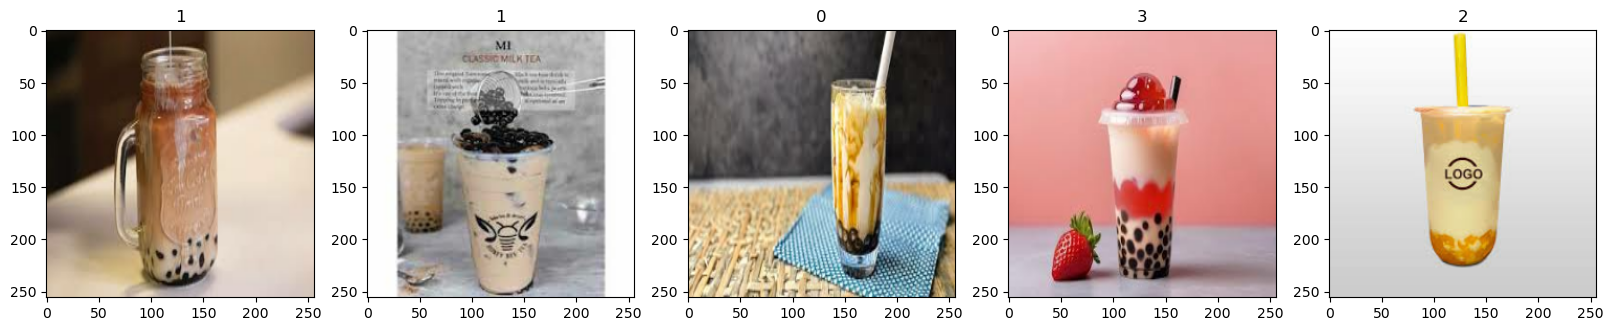

In [27]:
fig, ax = plt.subplots(ncols=5, figsize=(20,20))
for idx, img in enumerate(batch[0][:5]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [28]:
# map function scales data, make x value smaller bounded from 0 to 1 and y is the same
data = data.map(lambda x,y: (x/255, y))

In [29]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.05),
])

In [33]:
len(data)

64

In [35]:
#Splitting data into train, evaluate, and test
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [37]:
def preprocess_data(image, label):
    label = tf.cast(label, tf.int32)  # Ensure label is in integer format
    label = tf.one_hot(label, depth=5)  # Assuming 5 classes
    return image, label

In [39]:
#data partitioning 
#takes first train, skips train batch, takes val_size batch, skips both train and val batch and takes test_size batch for test
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [41]:
# Apply one-hot encoding to labels if using CategoricalCrossentropy
train = train.map(preprocess_data)
val = val.map(preprocess_data)
test = test.map(preprocess_data)

In [43]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
base_model.trainable = False

In [79]:
model = Sequential()
model.add(layers.Input(shape=(256, 256, 3)))  # Specify input shape here for the whole model
#model.add(base_model) #Pretrained ResNet model
model.add(data_augmentation)


model.add(Conv2D(16, (3,3), padding = 'same', activation='relu', kernel_regularizer=l2(0.01))) #input of 256 by 256 by 3 represents each image has a pixel of 256x256 with 3 colors RGB
model.add(MaxPooling2D()) #max pooling condenses data down
model.add(layers.BatchNormalization())  # Normalize after each Conv2D

model.add(Conv2D(32, (3,3), padding = 'same', activation='relu', kernel_regularizer=l2(0.01))) #32 filters, 3 by 3 block changed 32-64
model.add(MaxPooling2D()) #max pooling condenses data down
model.add(layers.BatchNormalization())  # Normalize after each Conv2D

model.add(Conv2D(64, (3,3), padding = 'same', activation='relu', kernel_regularizer=l2(0.01))) #changed from 32-64
model.add(MaxPooling2D()) #max pooling condenses data down
model.add(layers.BatchNormalization())  # Normalize after each Conv2D
model.add(Dropout(0.2))

model.add(Flatten()) #converting everything (30 by 30 by 16) into a single dimension

model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model.add(layers.BatchNormalization())  # Normalize after each Conv2D
# model.add(Dropout(0.1))

model.add(Dense(5, activation='softmax')) 

In [80]:
model.compile('adam', loss=tf.losses.CategoricalCrossentropy(), metrics=['accuracy'])

In [83]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 256, 256, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 128, 128, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 128, 128, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 128, 128, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 64, 64, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 65536)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │       4,194,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,218,981 (16.09 MB)

 Trainable params: 4,218,629 (16.09 MB)

 Non-trainable params: 352 (1.38 KB)

In [85]:
logdir = 'logs'

In [87]:
#logs progress
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [89]:
#figure out what these two do later
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [91]:
#takes in training data, run 20 epochs, validates after training, log everything in tensorboard
hist = model.fit(train, epochs=30, validation_data=val, callbacks=[tensorboard_callback,lr_scheduler, early_stopping])

Epoch 1/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 33s 640ms/step - accuracy: 0.5052 - loss: 3.8801 - val_accuracy: 0.2292 - val_loss: 4.0461 - learning_rate: 0.0010
Epoch 2/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 27s 612ms/step - accuracy: 0.7639 - loss: 2.9221 - val_accuracy: 0.3776 - val_loss: 3.2811 - learning_rate: 0.0010
Epoch 3/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 28s 628ms/step - accuracy: 0.8046 - loss: 2.0604 - val_accuracy: 0.3906 - val_loss: 2.8005 - learning_rate: 0.0010
Epoch 4/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 29s 663ms/step - accuracy: 0.8291 - loss: 1.6467 - val_accuracy: 0.2708 - val_loss: 2.8988 - learning_rate: 0.0010
Epoch 5/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 26s 581ms/step - accuracy: 0.8138 - loss: 1.5302 - val_accuracy: 0.4427 - val_loss: 2.1297 - learning_rate: 0.0010
Epoch 6/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 25s 574ms/step - accuracy: 0.8081 - loss: 1.4065 - val_accuracy: 0.4974 - val_loss: 2.1678 - learning_rate: 0.0010
Epoch 7/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 26s 576ms/step - accuracy: 0.8216 - loss: 1.

In [99]:
# shows log of history
hist.history

{'accuracy': [0.6051136255264282,
  0.7613636255264282,
  0.7713068127632141,
  0.8132102489471436,
  0.7904829382896423,
  0.7990056872367859,
  0.8125,
  0.84375,
  0.8302556872367859,
  0.8352272510528564,
  0.8423295617103577,
  0.8338068127632141,
  0.8416193127632141,
  0.8387784361839294,
  0.8373579382896423,
  0.8409090638160706,
  0.8565340638160706,
  0.8792613744735718,
  0.9005681872367859,
  0.9140625,
  0.9169034361839294,
  0.9133522510528564,
  0.921875,
  0.9161931872367859,
  0.9183238744735718,
  0.9126420617103577,
  0.9367897510528564,
  0.9346590638160706,
  0.9211647510528564,
  0.9289772510528564],
 'loss': [3.687857151031494,
  2.710944175720215,
  2.029514789581299,
  1.6241413354873657,
  1.5426932573318481,
  1.4118598699569702,
  1.3218744993209839,
  1.1879551410675049,
  1.146764874458313,
  1.1395198106765747,
  1.107173204421997,
  1.1033096313476562,
  1.0440905094146729,
  1.0690363645553589,
  1.0603432655334473,
  1.0358275175094604,
  1.0204905271

In [101]:
#model.save_weights("boba.weights.h5") 
#new_model = create_same_architecture_model()
#new_model.load_weights("boba.weights.h5") 

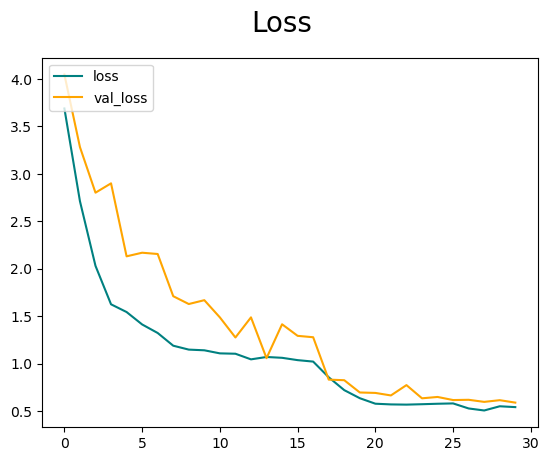

In [103]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

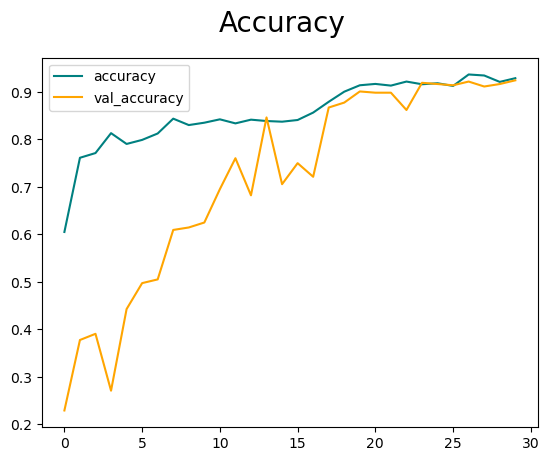

In [105]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [107]:
precision = Precision()
recall = Recall()
accuracy = CategoricalAccuracy()

In [109]:
#testing out batch in test
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    precision.update_state(y, yhat)
    recall.update_state(y, yhat)
    accuracy.update_state(y, yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


In [124]:
print(f'Precision: {precision.result().numpy():.2f}, Recall: {recall.result().numpy():.2f}, Accuracy: {accuracy.result().numpy():.2f}')

Precision: 0.92, Recall: 0.87, Accuracy: 0.90


In [119]:
def classify_tea(image_path, model):
    # Read the image using OpenCV
    img = cv2.imread(image_path)

    # Convert BGR to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Resizing the image
    resized_img = tf.image.resize(img, (256, 256))

    # Normalization to 0-1
    normalized_img = resized_img / 255.0

    # Expand dimensions to match the input shape of the model (batch size of 1)
    input_img = np.expand_dims(normalized_img, axis=0)

    # Predict using the model
    yhat = model.predict(input_img)

     # Get the predicted class index
    prediction = np.argmax(yhat, axis=1)[0]

    # Map prediction to tea type
    if prediction == 0: 
        print('This is a Brown Sugar Milk Tea')
    elif prediction == 1:
        print('This is a Classic Milk Tea')
    elif prediction == 2:
        print('This is a Mango Milk Tea')
    elif prediction == 3:
        print('This is a Strawberry Milk Tea')
    elif prediction == 4:
        print('This is a Taro Milk Tea')

In [122]:
classify_tea('brownsugar_test.jpg', model)
classify_tea('classic_test.jpg', model)
classify_tea('mango_test.jpg', model)
classify_tea('strawberry_test.jpg', model)
classify_tea('taro_test.jpeg', model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step
This is a Brown Sugar Milk Tea
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
This is a Classic Milk Tea
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
This is a Mango Milk Tea
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
This is a Strawberry Milk Tea
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
This is a Taro Milk Tea
